In [73]:
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages")

from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse 
import networkx as nx

In [3]:
def mcvalue(m, mbin):
    density = np.histogram(m, range = (min(m) - 1, max(m) + 1), density=True)
    return density[1][np.argmax(density[0])]

In [4]:
def haversine(lat1, lon1, lat2, lon2):
    """
    To calculate the L2 distance on the sphere
    """
    rad=np.pi/180
    dlat=lat2-lat1
    dlon=lon2-lon1
    R=6372.795477598
    a=(np.sin(rad*dlat/2))**2 + np.cos(rad*lat1)*np.cos(rad*lat2)*(np.sin(rad*dlon/2))**2
    distancia=2*R*np.arcsin(np.sqrt(a))
    return distancia

In [5]:
def dist_quakes(catalogo, B, c, d):
    """
    Returns matrix with the distances between earthquakes. If the value is negative
    then earthquake i happened after earthquake j.
    The geographical distance used is the product metric (haversine^2 + L2^2)^1/2 (which
    won't be truthful for long distances)
    """
    distancias = np.zeros(shape=(catalogo.shape[0], catalogo.shape[0]))
    for i in range(catalogo.shape[0]):
        for j in range(i+1, catalogo.shape[0]):
            sismo_i = catalogo.iloc[i,:]
            sismo_j = catalogo.iloc[j,:]
            
            tau = sismo_j["timestamp"] - sismo_i["timestamp"]
            tau = tau.total_seconds() # The time scale will be in seconds
            
            r = np.sqrt(haversine(sismo_i["Longitud"], sismo_j['Longitud'],
                        sismo_i['Latitud'], sismo_j['Latitud'])**2 + 
                        (sismo_j['Profundidad']-sismo_i['Profundidad'])**2 )
            delta_m = sismo_j["Magnitud"] - sismo_i["Magnitud"]
            
            distancias[i,j] = c*tau* (r**d) *(10**(-B * delta_m))
             
    return distancias           

In [24]:
def dist_quakes_sparse(catalogo, B, c, d, max_cluster=1000):
    """
    Returns matrix with the distances between earthquakes and the previous max_cluster earthquakes.
    The geographical distance used is the product metric (haversine^2 + L2^2)^1/2 (which
    won't be truthful for long distances)
    """
    lat=catalogo['Latitud'].to_numpy()
    long=catalogo['Longitud'].to_numpy()
    mag=catalogo["Magnitud"].to_numpy()
    time=((catalogo["timestamp"] - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')).to_numpy()
    time=time/(60*60*24*365.2425)
    depth=catalogo['Profundidad'].to_numpy()
    distancias = np.zeros(shape=(catalogo.shape[0], max_cluster))
    for i in range(max_cluster):
        
        lat_shift= np.concatenate([np.zeros(i+1),lat[:-(i+1)]])
        long_shift=np.concatenate([ np.zeros(i+1),long[:-(i+1)]])
        mag_shift=np.concatenate([ np.zeros(i+1),mag[:-(i+1)]])
        time_shift=np.concatenate([np.zeros(i+1),time[:-(i+1)]])
        depth_shift=np.concatenate([ np.zeros(i+1),depth[:-(i+1)]])

            
        tau = time-time_shift
        r = np.sqrt(haversine(long, long_shift,
                        lat, lat_shift)**2 + 
                        (depth-depth_shift)**2 )

        delta_m = mag_shift -np.repeat(3,catalogo.shape[0] )
            
        distancias[:,i] = c*tau* (r**d) *(10**(-B * delta_m))
        distancias[:i,i]=np.infty 
        
        #print('finished shift =  ', str(i))
    return distancias     

array([3, 3, 3, ..., 3, 3, 3])

In [7]:
sismos = pd.read_csv(".//SSNMX_catalogo_20170901_20210510_lat12d85_18d66_lon-97d26_-88d69.csv",  skiprows=4)
sismos= sismos.dropna()
sismos

,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Fecha UTC,Hora UTC,Estatus
0,2017-09-01,01:26:16,3.4,15.9832,-96.9505,25.8,"18 km al NORESTE de PUERTO ESCONDIDO, OAX",2017-09-01,06:26:16,revisado
1,2017-09-01,01:29:47,3.5,16.6938,-95.1257,94.8,"15 km al NORTE de CD IXTEPEC, OAX",2017-09-01,06:29:47,revisado
2,2017-09-01,02:10:55,3.8,15.5425,-92.4787,187.6,"32 km al NOROESTE de MOTOZINTLA, CHIS",2017-09-01,07:10:55,revisado
3,2017-09-01,02:15:28,3.5,16.0508,-97.1588,26.3,"23 km al NOROESTE de PUERTO ESCONDIDO, OAX",2017-09-01,07:15:28,revisado
4,2017-09-01,02:24:18,3.6,17.1730,-94.9790,121.0,"34 km al NORTE de MATIAS ROMERO, OAX",2017-09-01,07:24:18,revisado
...,...,...,...,...,...,...,...,...,...,...
54557,2021-05-10,02:10:19,3.8,15.9500,-95.6600,54.0,"54 km al NORESTE de CRUCECITA, OAX",2021-05-10,07:10:19,verificado
54558,2021-05-10,02:15:51,3.9,17.4100,-94.8400,144.0,"53 km al SUR de SAYULA DE ALEMAN, VER",2021-05-10,07:15:51,verificado
54559,2021-05-10,03:35:19,3.9,14.9200,-94.0200,14.0,"121 km al SUROESTE de PIJIJIAPAN, CHIS",2021-05-10,08:35:19,verificado
54560,2021-05-10,05:13:42,4.5,14.0000,-92.1500,43.0,"75 km al SUR de CD HIDALGO, CHIS",2021-05-10,10:13:42,verificado


In [8]:
sismos["timestamp"] = sismos['Fecha'] + ' ' +sismos['Hora']
sismos["timestamp"] = sismos["timestamp"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
sismos.drop(['Fecha UTC','Hora UTC', 'Estatus'], 1)

,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,timestamp
0,2017-09-01,01:26:16,3.4,15.9832,-96.9505,25.8,"18 km al NORESTE de PUERTO ESCONDIDO, OAX",2017-09-01 01:26:16
1,2017-09-01,01:29:47,3.5,16.6938,-95.1257,94.8,"15 km al NORTE de CD IXTEPEC, OAX",2017-09-01 01:29:47
2,2017-09-01,02:10:55,3.8,15.5425,-92.4787,187.6,"32 km al NOROESTE de MOTOZINTLA, CHIS",2017-09-01 02:10:55
3,2017-09-01,02:15:28,3.5,16.0508,-97.1588,26.3,"23 km al NOROESTE de PUERTO ESCONDIDO, OAX",2017-09-01 02:15:28
4,2017-09-01,02:24:18,3.6,17.1730,-94.9790,121.0,"34 km al NORTE de MATIAS ROMERO, OAX",2017-09-01 02:24:18
...,...,...,...,...,...,...,...,...
54557,2021-05-10,02:10:19,3.8,15.9500,-95.6600,54.0,"54 km al NORESTE de CRUCECITA, OAX",2021-05-10 02:10:19
54558,2021-05-10,02:15:51,3.9,17.4100,-94.8400,144.0,"53 km al SUR de SAYULA DE ALEMAN, VER",2021-05-10 02:15:51
54559,2021-05-10,03:35:19,3.9,14.9200,-94.0200,14.0,"121 km al SUROESTE de PIJIJIAPAN, CHIS",2021-05-10 03:35:19
54560,2021-05-10,05:13:42,4.5,14.0000,-92.1500,43.0,"75 km al SUR de CD HIDALGO, CHIS",2021-05-10 05:13:42


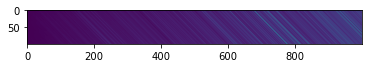

In [29]:
m = sismos['Magnitud'].values
m = m[~np.isnan(m)]
mbin = 0.1 
Mc = mcvalue(m, mbin)
# Aki ML estimates
B = np.log10(np.e)/(m[m>Mc-mbin/2].mean() - (Mc-mbin/2))
#d = len(m[m>0])
d = 2*B

#Arbitrary c. (We don't know what it is)
#We're also not entirely sure about the d. We need to find more sources.
dist_matrix=dist_quakes_sparse(sismos, B, 1, d)
plt.imshow(dist_matrix[-100:,:])


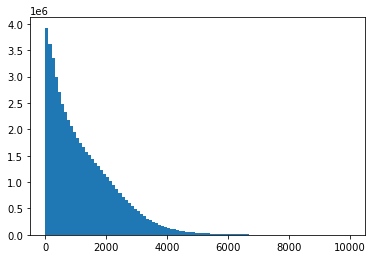

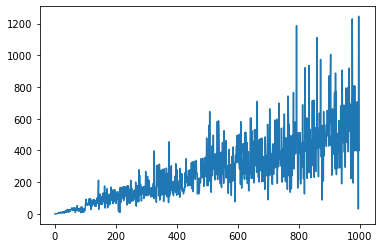

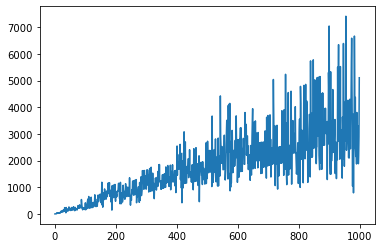

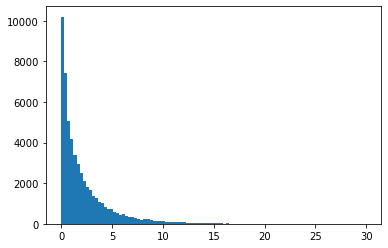

In [41]:

plt.hist(dist_matrix.flatten()[np.abs(dist_matrix.flatten())<1e4], bins =100)
plt.show() # Histogram of all values in the distance matrix


plt.plot(range(1000), dist_matrix[5000])
plt.show() #An example of the distance between one earthquake and 1000 previous
plt.plot(range(1000), dist_matrix[50000])
plt.show() #An example of the distance between one earthquake and 1000 previous

next_time=np.min(dist_matrix,axis=1) #Histogram of the distance between earthquakes and closest earthquake 
plt.hist(next_time[next_time <30], bins =100)
plt.show()

In [110]:
#Nearest neighbour pairs
nn=[] #To store edges in upcoming graph 

for i in range(sismos.shape[0]):
    
    if np.min(dist_matrix[i,:])<3: # This number 3 can be changed and was chosen arbitrarily 
        nn.append([i, int(-np.argmin(dist_matrix[i,:])+i-1)])

nn[:100]

[[1, 0],
 [3, 2],
 [4, 2],
 [6, 5],
 [7, 6],
 [8, 7],
 [9, 8],
 [10, 9],
 [12, 11],
 [14, 13],
 [15, 14],
 [22, 21],
 [27, 26],
 [28, 27],
 [30, 29],
 [31, 30],
 [32, 31],
 [33, 32],
 [35, 34],
 [36, 35],
 [39, 38],
 [42, 41],
 [46, 45],
 [51, 50],
 [52, 51],
 [53, 52],
 [55, 54],
 [56, 55],
 [57, 56],
 [60, 59],
 [65, 64],
 [66, 65],
 [67, 66],
 [68, 66],
 [69, 68],
 [70, 69],
 [71, 70],
 [72, 70],
 [73, 72],
 [76, 75],
 [79, 78],
 [82, 81],
 [85, 84],
 [87, 86],
 [93, 92],
 [94, 93],
 [97, 96],
 [100, 99],
 [102, 101],
 [108, 107],
 [109, 107],
 [110, 109],
 [111, 110],
 [112, 107],
 [113, 112],
 [114, 113],
 [117, 116],
 [119, 118],
 [122, 121],
 [124, 123],
 [125, 124],
 [128, 127],
 [131, 130],
 [132, 131],
 [134, 133],
 [135, 133],
 [136, 133],
 [137, 133],
 [138, 133],
 [139, 133],
 [140, 133],
 [141, 133],
 [142, 133],
 [143, 133],
 [144, 133],
 [145, 133],
 [146, 133],
 [147, 133],
 [148, 133],
 [149, 133],
 [150, 133],
 [151, 133],
 [152, 133],
 [153, 133],
 [154, 133],
 [155

In [126]:
#Build the graph and find the connected components
G = nx.Graph()
G.add_nodes_from(range(1000))
G.add_edges_from(nn)
clusters=list(nx.connected_components(G))
clusters[:100]
import csv
with open('Nearest_neightbour_earthquake_clusters_r0_3.csv', 'w') as f:
      
    # using csv.writer method from CSV package
    write = csv.writer(f)
      
    write.writerows(clusters)

In [122]:
#Find the centroids
centroids=[]
for i in range(len(clusters)):
    centroids.append(np.array(list(clusters[i]))[np.argmax(m[np.array(list(clusters[i]))])])
centroids[200:300]                

np.save('Nearest_neightbour_earthquake_centres_r0_3.npy', centroids)

In [118]:
sismos_centroids=sismos.iloc[centroids,:]

In [120]:
sismos_centroids

,Fecha,Hora,Magnitud,Latitud,Longitud,Profundidad,Referencia de localizacion,Fecha UTC,Hora UTC,Estatus,timestamp
1,2017-09-01,01:29:47,3.5,16.6938,-95.1257,94.8,"15 km al NORTE de CD IXTEPEC, OAX",2017-09-01,06:29:47,revisado,2017-09-01 01:29:47
2,2017-09-01,02:10:55,3.8,15.5425,-92.4787,187.6,"32 km al NOROESTE de MOTOZINTLA, CHIS",2017-09-01,07:10:55,revisado,2017-09-01 02:10:55
5,2017-09-01,03:25:16,4.3,15.7820,-94.9405,16.1,"52 km al SURESTE de SALINA CRUZ, OAX",2017-09-01,08:25:16,revisado,2017-09-01 03:25:16
11,2017-09-01,05:56:09,3.5,15.7290,-95.4693,37.9,"58 km al SUROESTE de SALINA CRUZ, OAX",2017-09-01,10:56:09,revisado,2017-09-01 05:56:09
13,2017-09-01,08:43:52,4.4,15.5892,-93.3158,100.3,"16 km al SUROESTE de PIJIJIAPAN, CHIS",2017-09-01,13:43:52,revisado,2017-09-01 08:43:52
...,...,...,...,...,...,...,...,...,...,...,...
54544,2021-05-09,12:22:33,3.8,16.1900,-95.0100,16.0,"19 km al ESTE de SALINA CRUZ, OAX",2021-05-09,17:22:33,verificado,2021-05-09 12:22:33
54548,2021-05-09,13:55:42,4.1,14.6500,-93.3700,22.0,"101 km al SUROESTE de MAPASTEPEC, CHIS",2021-05-09,18:55:42,verificado,2021-05-09 13:55:42
54552,2021-05-09,17:26:50,3.5,16.9600,-95.6600,16.0,"67 km al OESTE de MATIAS ROMERO, OAX",2021-05-09,22:26:50,verificado,2021-05-09 17:26:50
54555,2021-05-09,23:46:15,4.0,16.6700,-95.4000,65.0,"34 km al NOROESTE de CD IXTEPEC, OAX",2021-05-10,04:46:15,verificado,2021-05-09 23:46:15
